In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme()

In [2]:
main_data = pd.read_csv("data/train_users_2.csv")
main_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [4]:
def clear_data(main_data):
    # set appropriate data types
    int_time_to_str = lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8] + ' ' + x[8:10] + ':' + x[10:12] + ':' + x[12:]

    main_data["date_account_created"] = main_data["date_account_created"].astype("datetime64[ns]")
    main_data["timestamp_first_active"] = main_data["timestamp_first_active"].astype(str) \
                                                                             .apply(int_time_to_str) \
                                                                             .astype("datetime64[ns]")
    main_data["date_first_booking"] = main_data["date_first_booking"].astype("datetime64[ns]")
    main_data["signup_flow"] = main_data["signup_flow"].astype(str)
    
    # Dealing with NaN values and clearing dataset
    
    main_data = main_data[(main_data["age"] < 100) | (main_data["age"].isnull())]
    main_data = main_data.dropna(subset=["first_affiliate_tracked"])
    main_data = main_data.drop("date_first_booking", axis=1)
    
    ages = main_data.groupby(["gender", "country_destination"]).mean().reset_index()
    ages = ages.rename(columns={"age": "mean_age"})
    ages["mean_age"] = ages["mean_age"].round()
    main_data = main_data.merge(ages, on=["gender", "country_destination"])
    main_data["age"] = main_data["age"].fillna(main_data["mean_age"])
    main_data = main_data.drop("mean_age", axis=1)
    
    return main_data

In [5]:
cleared_data = clear_data(main_data)

In [6]:
cleared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205065 entries, 0 to 205064
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       205065 non-null  object        
 1   date_account_created     205065 non-null  datetime64[ns]
 2   timestamp_first_active   205065 non-null  datetime64[ns]
 3   gender                   205065 non-null  object        
 4   age                      205065 non-null  float64       
 5   signup_method            205065 non-null  object        
 6   signup_flow              205065 non-null  object        
 7   language                 205065 non-null  object        
 8   affiliate_channel        205065 non-null  object        
 9   affiliate_provider       205065 non-null  object        
 10  first_affiliate_tracked  205065 non-null  object        
 11  signup_app               205065 non-null  object        
 12  first_device_typ

### Feature extraction

In [7]:
cleared_data["year_account_created"] = pd.DatetimeIndex(cleared_data["date_account_created"]).year

In [8]:
cleared_data["year_account_created"].value_counts()

2013    81214
2014    74935
2012    37698
2011     9241
2010     1977
Name: year_account_created, dtype: int64

## EDA

### IDs per destination country plot

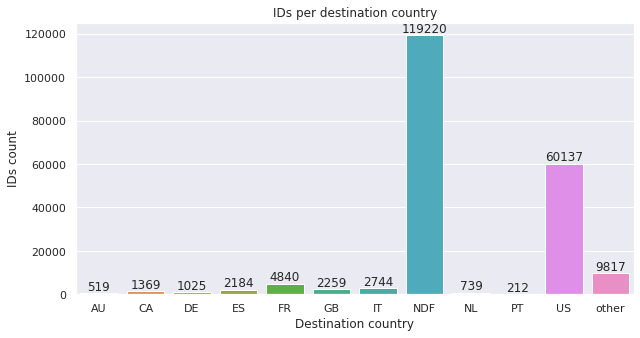

In [7]:
fig = plt.figure(figsize=(10, 5))

country_data = cleared_data.groupby(["country_destination"]).count().reset_index()[["country_destination", "id"]]

ax = sns.barplot(x=country_data["country_destination"], 
                 y=country_data["id"])
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Destination country")
plt.ylabel("IDs count")
plt.title("IDs per destination country");

### Median age per destination country

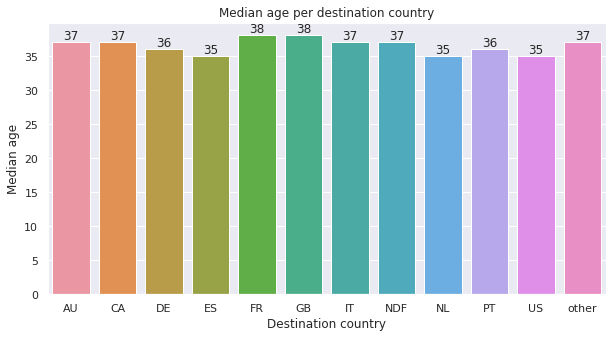

In [8]:
fig = plt.figure(figsize=(10, 5))

country_data = cleared_data.groupby(["country_destination"]).median().reset_index()[["country_destination", "age"]]

ax = sns.barplot(x=country_data["country_destination"], 
                 y=country_data["age"])
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Destination country")
plt.ylabel("Median age")
plt.title("Median age per destination country");

### Ages distribution

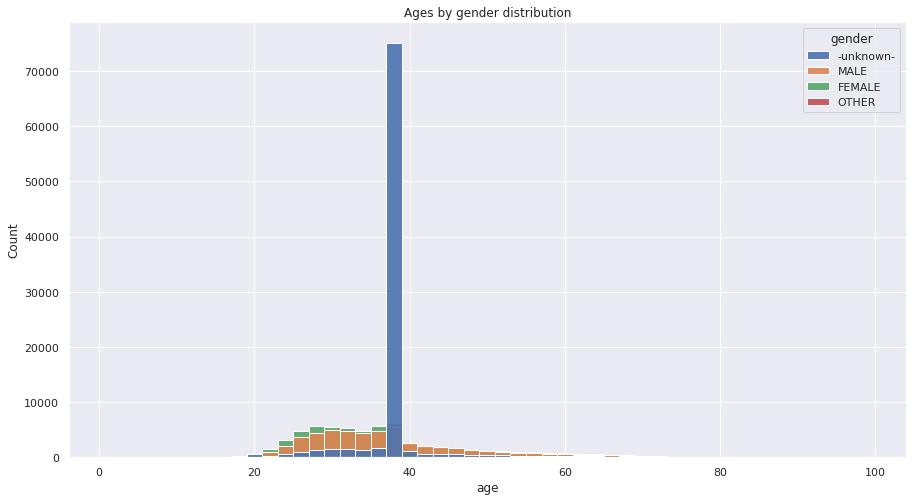

In [9]:
plt.figure(figsize=(15, 8))
sns.histplot(cleared_data, x="age", hue="gender", binwidth=2, alpha=0.9);

plt.title("Ages by gender distribution");

## Plots with arguments
args:
- signup_app
- signup_method
- affiliate_provider
- gender
- signup_flow
- affiliate_channel
- first_affiliate_tracked
- first_device_type
- first_browser
- country_destination

### Piechart with different arguments

In [10]:
arg = "gender"

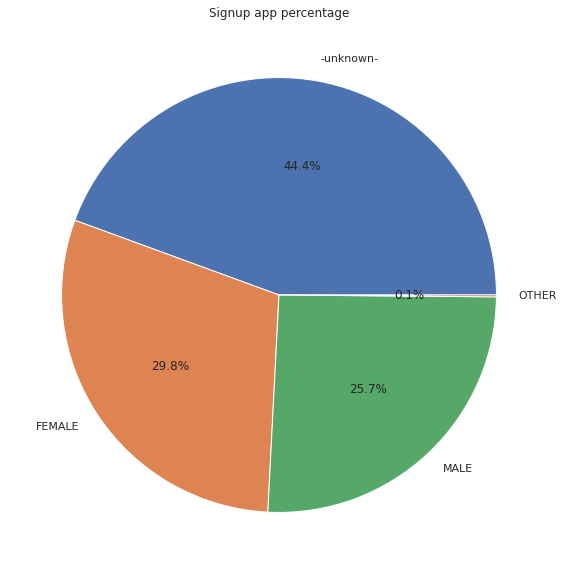

In [11]:
fig = plt.figure(figsize=(10, 10))
signup_data = cleared_data.groupby([arg]).count().reset_index()[[arg, "id"]]

plt.pie(signup_data["id"], 
        labels=signup_data[arg], 
        autopct='%1.1f%%')

plt.title("Signup app percentage");

### Treemap with different arguments

In [12]:
arg = "affiliate_provider"

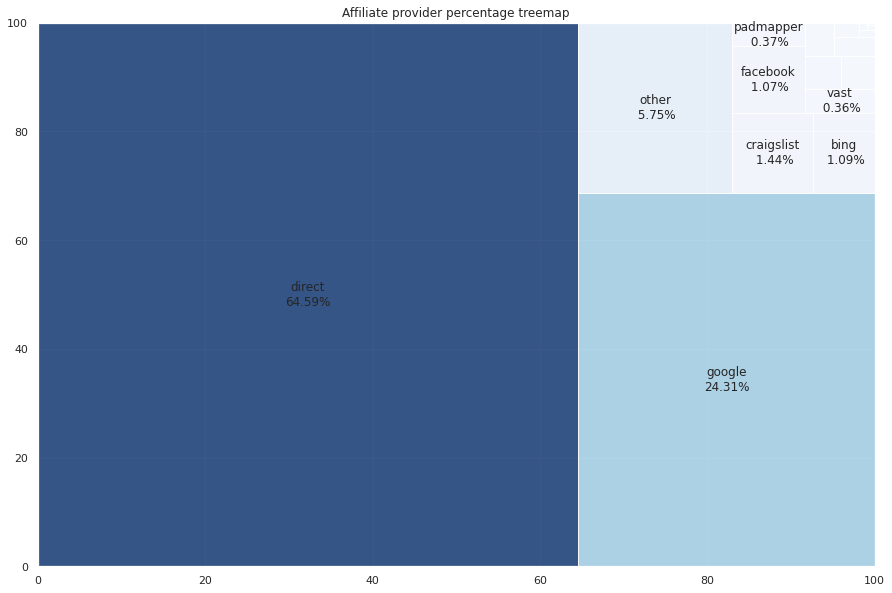

In [13]:
fig = plt.figure(figsize=(15, 10))
signup_data = cleared_data.groupby([arg]).count().reset_index()[[arg, "id"]]
signup_data = signup_data.sort_values(by="id", ascending=False)

cmap = matplotlib.cm.Blues
mini=min(signup_data["id"])
maxi=max(signup_data["id"])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in signup_data["id"]]

lbl = signup_data[arg]
percentages = [str('{:5.2f}'.format(i / signup_data["id"].sum()*100)) + "%" for i in signup_data["id"]]
lbl_perc = list(zip(lbl, percentages))
lbl_perc = [l_p[0] + "\n" + l_p[1] for l_p in lbl_perc]
lbl_perc = [lbl_perc[i] if i < 8 else "" for i in range(len(lbl_perc))]

squarify.plot(sizes=signup_data['id'], label=lbl_perc, color=colors, alpha=0.8)
plt.title("Affiliate provider percentage treemap");

### IDs per destination country with different arguments

In [9]:
arg = "year_account_created"

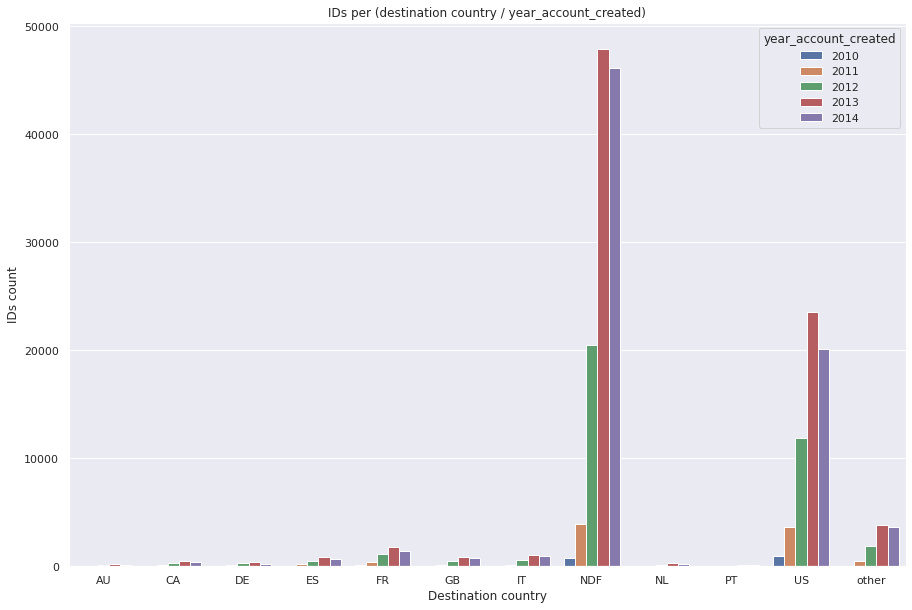

In [10]:
fig = plt.figure(figsize=(15, 10))
country_app_data = cleared_data.groupby(["country_destination", arg]).count().reset_index()[["country_destination", arg, "id"]]

sns.barplot(x=country_app_data["country_destination"], 
            y=country_app_data["id"], 
            hue=country_app_data[arg])

plt.xlabel("Destination country")
plt.ylabel("IDs count")
plt.title(f"IDs per (destination country / {arg})");

### Check median age per destination country with different arguments

In [11]:
plot_y = "age"
plot_hue = "year_account_created"

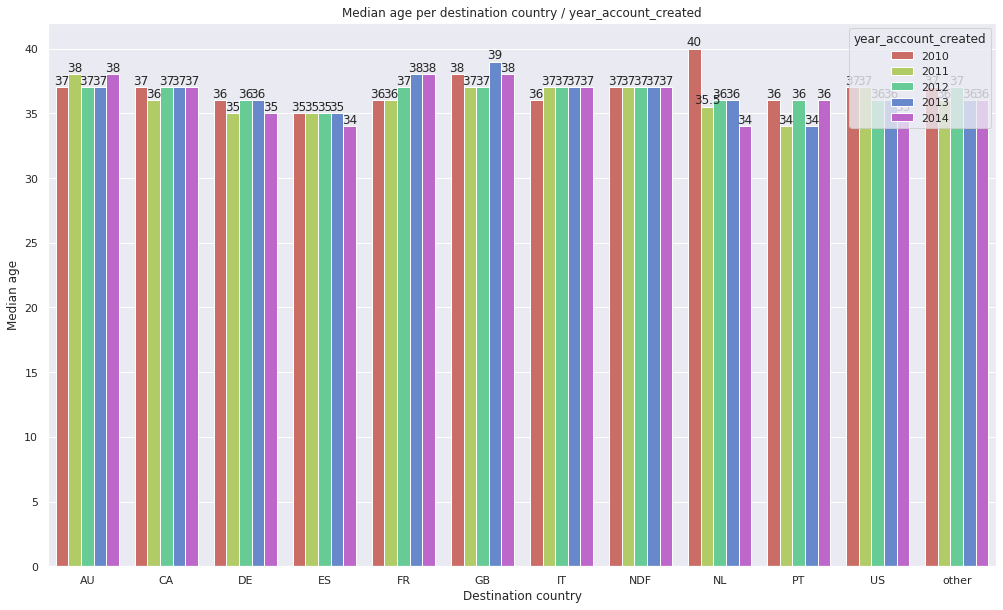

In [12]:
fig = plt.figure(figsize=(17, 10))
country_app_age_data = cleared_data.groupby(["country_destination", plot_hue]).median().reset_index()[["country_destination", plot_hue, plot_y]]

ax = sns.barplot(x=country_app_age_data["country_destination"], 
                 y=country_app_age_data[plot_y], 
                 hue=country_app_age_data[plot_hue],
                 palette="hls")
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Destination country")
plt.ylabel("Median age")
plt.title(f"Median age per destination country / {plot_hue}");

In [13]:
cleared_data.to_csv("data/train_users_processed.csv", index=False)